SVM sirve muy bien para conjuntos de datos pequeños y medianos no lineales pero no escalan bien para conjuntos de datos muy grande

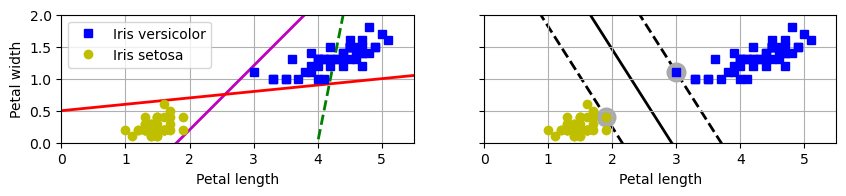

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.show()

## Clasificación lineal SVM

En la imagen se ve que las dos clases pueden ser separadas con una linea recta (son linealmente separables). en la izquierda se muestran los limites de decisión de tres clasificadores, la linea punteada clasifica muy mal, las otras dos lineas clasifican tan bien estos datos que lo más probable es que no generalicen, ahora, la linea en la derecha representa el limite de decisión de un SVM, separa las dos clases pero también se aleja de las observaciones más cercanas como sea posible, esto se llama *large margin classification*.

Añadir más observaciones no va a afectar el limite de decisión, este se genera solo con las observaciones en el limite de las otras. Estas observaciones se llaman *Support vectors*.

SVM son sensibles a las escalas, lo mejor es escalar los datos antes.

### Soft margin classification

Si imponemos que todas las observaciones deben estar fuera de la linea punteada (calle) y en el lado correcto, esto se llama *hard margin classification*. Hay dos problemas con esto, solo funciona si los datos son linealmente separables y es sensible a outliers, por ejemplo:

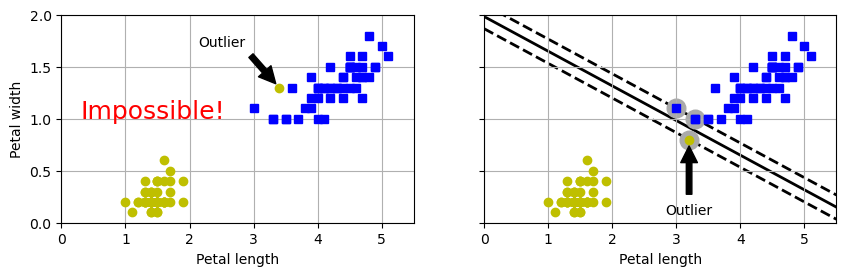

In [2]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", color="red", fontsize=18)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.annotate(
    "Outlier",
    xy=(X_outliers[0][0], X_outliers[0][1]),
    xytext=(2.5, 1.7),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(3.2, 0.08),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()

A la derecha es imposible encontrar un margen duro, a la derecha el limite de decisión es muy diferente al anterior, el modelo no va a generalizar bien, para evitar estos problemas usamos un modelo más flexible, necesitamos encontrar un equilibrio entre calles con grandes distancias y violaciones del margen, esto se llama *soft margin classification*.

Al crear un modelo SVM en scikit se pueden especificar varios hiperparámetros, incluyendo un hiperparametro de regularización C, reducir C hace las calles mas largas, pero lleva a más violaciones de margenes, reducir C resulta en más observaciones soportando la calle, menos riesgo de sobreajustar, si se reduce mucho el modelo termina subajustando.

Se hace una ejemplo que entrena un clasificador lineal SVM para detectar Iris virginica.

In [104]:
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [4]:
iris = load_iris(as_frame = True)
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = (iris.target == 2) # Virginica

In [5]:
svm_clf = make_pipeline(StandardScaler(),
                       LinearSVC(C = 1, random_state = 42))
svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

In [6]:
X_new = [[5.5, 1.7], [5.0, 1.5]]
svm_clf.predict(X_new)

array([ True, False])

In [7]:
svm_clf.decision_function(X_new)

array([ 0.66163411, -0.22036063])

LinearSVC no tiene un metodo predict_proba(), si se usa la clase SVC y se establece el parámetro probability a True, el modelo ajusta un modelo extra que mapea la función puntaje de decisión del SVC a probabilidades estimadas, luego los metodos predict_proba() y predict_log_proba() estarán disponibles.

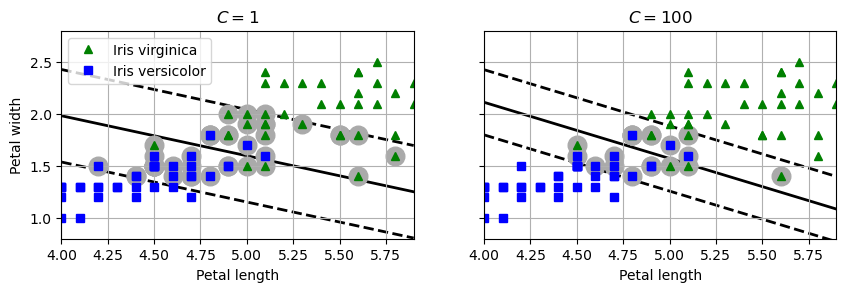

In [8]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, max_iter=10_000, random_state=42)
svm_clf2 = LinearSVC(C=100, max_iter=10_000, random_state=42)

scaled_svm_clf1 = make_pipeline(scaler, svm_clf1)
scaled_svm_clf2 = make_pipeline(scaler, svm_clf2)

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf1.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length")
plt.title(f"$C = {svm_clf2.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

plt.show()

### Clasificación SVM no lineal

Muchos datos no están ni cerca de ser separables linealmente, una idea incial es agregar un polinomio al modelo, en algunos casos esto puede lograr que un conjunto de datos se vuelva linearmente separable, por ejemplo el siguiente, con una variable x no es linearmente separable, al añadir la variable $x^2$ se vuelve linearmente separable.

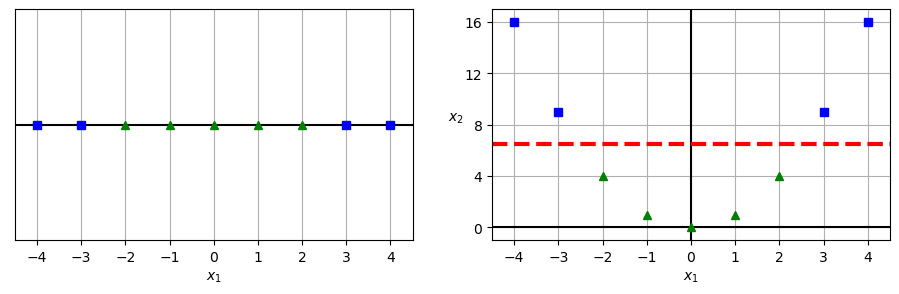

In [9]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel("$x_1$")
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$  ", rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

plt.show()

Para implementar esto en scikit se puede crear una pipeline que contenga el transformador PolynomialFeatures seguido de un escalador y el clasificador. por ejemplo:

In [10]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples = 100, noise = 0.15, random_state = 42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree = 3),
    StandardScaler(),
    LinearSVC(C = 10, max_iter = 10_000, random_state = 42)
)

polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

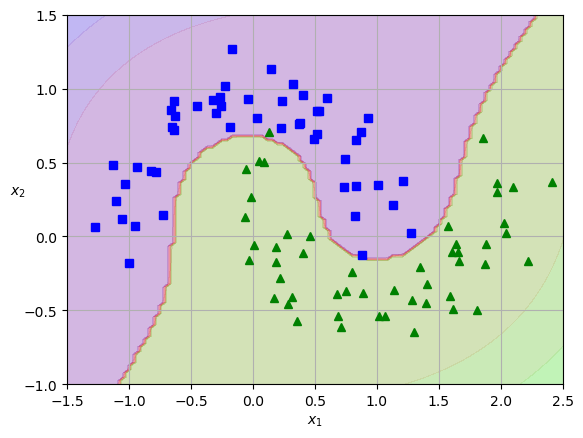

In [11]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])


plt.show()

## Polinomio kernel

Añadir polinomios es una solución sencilla pero un polinomio bajo no puede aguantar conjuntos de datos complejos y con un polinomio alto se crean muchas variables haciendo el modelo lento.

Al usar SVM se puede aplicar el *truco kernel*, este truco hace posible tener el mismo resultado que haber añadido muchas variables polinomicas sin tener que añadirlas, se puede aplicar asi:

In [12]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel = 'poly', degree = 3, coef0 = 1, C = 5))
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

Este código entrena un clasificador SVM usando un polinomio de tercer grado, a continuación se compara con un polinomio de grado 10, si el modelo está sobreajustando se debería reducir el grado del polinomio, el hiperparámetro coef0 controla que tanto el modelo es influenciado por un terminos de alto grado vs terminos de poco grado.

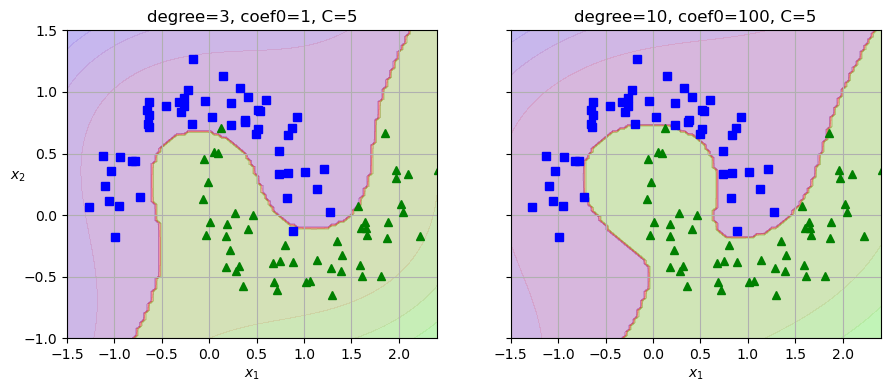

In [13]:
poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=3, coef0=1, C=5")

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=10, coef0=100, C=5")
plt.ylabel("")

plt.show()

### Similaridad de variables

Otra forma de resolver el problema de no linealidad es agregar variables computadas usando una función de similitud la cual mide que tanto cada observación se parece a un *punto de referencia*.

Por ejemplo tenemos dos puntos de referencia, $x_1 = -2$ y $x_1 = 1$, definimos la función de similitud para que sea una gaussiana RBF con $\gamma = 0.3$, esta es una función con forma de campana que varía de 0 (muy lejos del punto de referencia) a 1 (el punto de referencia).

Ahora se computan las nuevas variables, por ejemplo la observación en $x_1 = -1$, está a una distancia de 1 del primer punto de referencia y a 2 del segundo, por lo tanto la nueva variable será $x_2 = \exp(-0.3\times1^2) \approx 0.74$ y $x_3 = \exp(-0.3 \times 2^2) \approx 0.3$

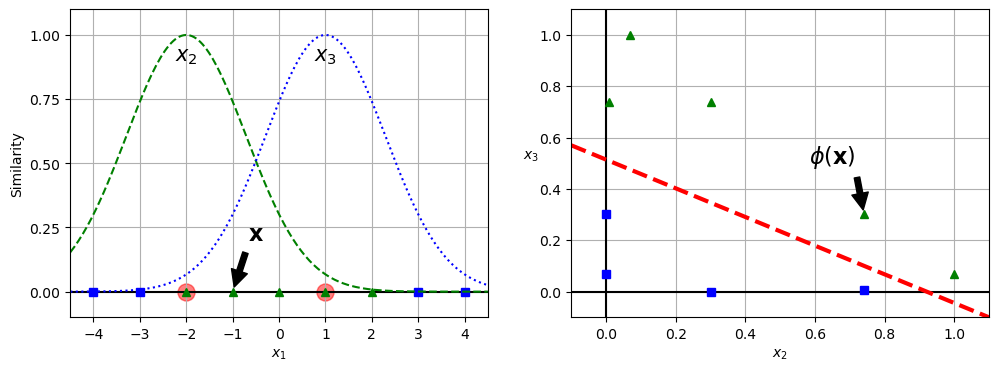

In [14]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel("$x_1$")
plt.ylabel("Similarity")
plt.annotate(
    r'$\mathbf{x}$',
    xy=(X1D[3, 0], 0),
    xytext=(-0.5, 0.20),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=15)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=15)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel("$x_2$")
plt.ylabel("$x_3$  ", rotation=0)
plt.annotate(
    r'$\phi\left(\mathbf{x}\right)$',
    xy=(XK[3, 0], XK[3, 1]),
    xytext=(0.65, 0.50),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

plt.show()

Ahora con las nuevas variables son linealmente separables. Para seleccionar los puntos de referencia el metodo más simple es crear un punto de referencia en la ubicación de cada una de las observaciones del conjunto de datos, al hacer esto crea muchas dimensiones y aumenta la posibilidad de que el conjunto transformado sea linearmente separable, lo malo es que el conjunto transformado pasa de tener dimensiones nxm a mxm.

### Kernel Gaussiano RBF

El metodo de similitudes puede ser útil en cualquier algoritmo, pero puede ser pesado computar las nuevas variables, una vez más el truco del kernel hace posible obtener resultados similares al de haber agregado muchas variables sin hacerlo, por ejemplo:

In [15]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel = 'rbf', gamma = 5, C = 0.001))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

Vamos a ver este modelo con diferentes hiperparámetros

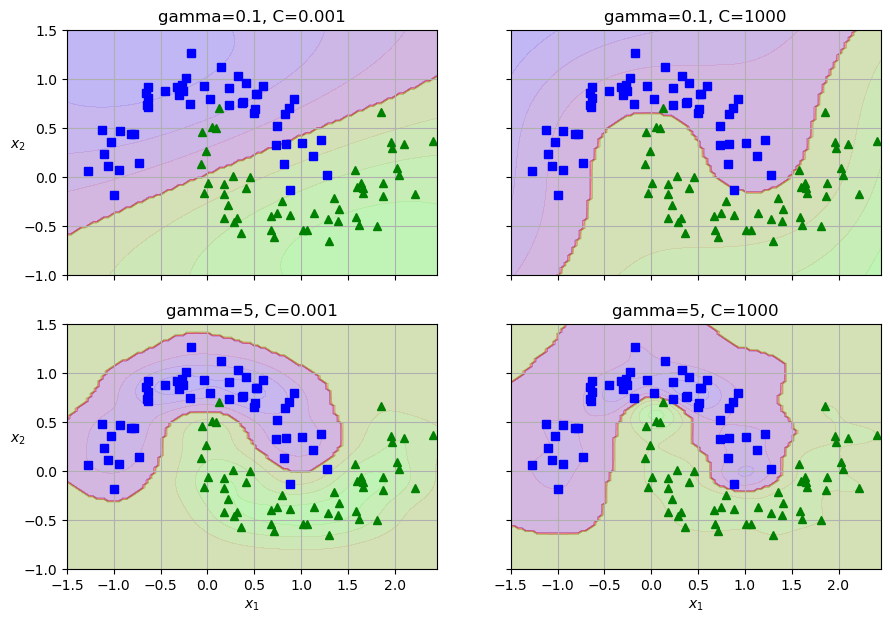

In [16]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(f"gamma={gamma}, C={C}")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

Incrementar gamma hace que la curva en forma de campana sea más estrecha, las observaciones tienen un rango de influencia más pequeño haciendo que el limite de decisión sea más irregular. Un gamma más pequeño hace que la curva en forma de campana sea más ancha, las observaciones tienen un rango de influencia más largo y el limite de decisión es más suave, gamma $\gamma$ actua como una parámetro de regularización, si el modelo sobreajusta se debe reducir $\gamma$, similar al hiperparámetro C.

Existen otros kernels pero son más especiales para otros tipos de clasificación, por ejemplo el *string kernel* se usan en clasificación de texto o secuencias de DNA.

Primero se debería tratar con el kernel lineal (LinearSVC es mucho mas rapido que SVC(kernel = "linear")), luego se debería intentar con el kernel Gaussiano RBF, casi siempre funciona bien, luego, si hay un kernel especializado para el problema se debería intentar ese.

### Clases de SVM y complejidad computacional

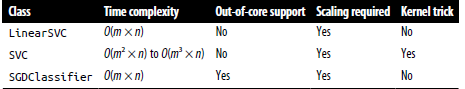

## Regresión SVM

En vez de ajustar las calles mas largas posibles entre dos clases minetras se limita la violación de margenes, la regresión trata de ajustar tantas observaciones como se pueda en la calle mientras se mantienen el margen de limitaciones, el ancho de la calle se controla con un hiperparámetro $\epsilon$, añadir más observaciones no afecta las predicciones, este modelo se dice que es $\epsilon$ sensible, por ejemplo:

In [17]:
from sklearn.svm import LinearSVR

np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

svm_reg = make_pipeline(StandardScaler(),
                       LinearSVR(epsilon = 0.5, random_state = 42))
svm_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(epsilon=0.5, random_state=42))])

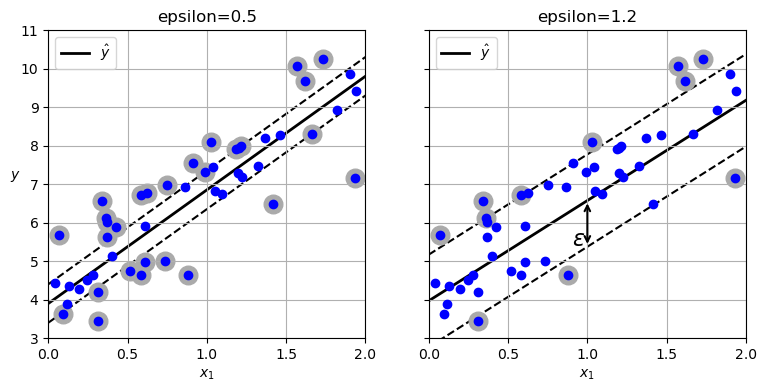

In [18]:
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon
    off_margin = np.abs(y - y_pred) >= epsilon
    return np.argwhere(off_margin)

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
    plt.scatter(X[svm_reg._support], y[svm_reg._support], s=180,
                facecolors='#AAA', zorder=-1)
    plt.plot(X, y, "bo")
    plt.xlabel("$x_1$")
    plt.legend(loc="upper left")
    plt.axis(axes)

svm_reg2 = make_pipeline(StandardScaler(),
                         LinearSVR(epsilon=1.2, random_state=42))
svm_reg2.fit(X, y)

svm_reg._support = find_support_vectors(svm_reg, X, y)
svm_reg2._support = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg2[-1].epsilon}")
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.90, 5.4, r"$\epsilon$", fontsize=16)
plt.grid()
plt.show()

Para encontrar regresiones no lineales, se puede hacer un modelo SVM kernelizado, se presentan dos gráficas usando un kernel de segundo grado, con alguna regularización en la izquierda y mucha menos en la derecha, se usa la clase SVR

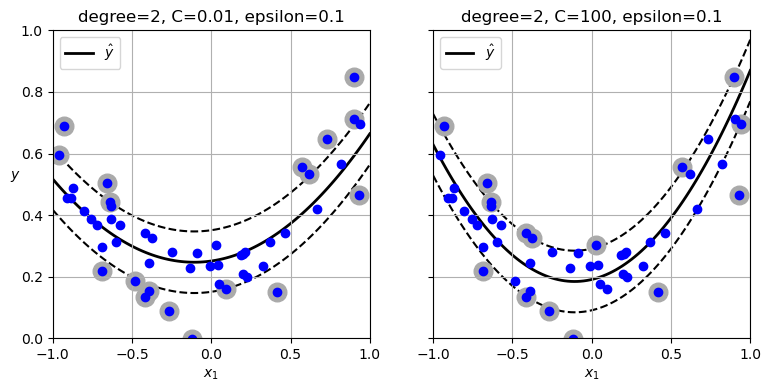

In [19]:
from sklearn.svm import SVR

np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

svm_poly_reg = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg.fit(X, y)

svm_poly_reg2 = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=100))
svm_poly_reg2.fit(X, y)

svm_poly_reg._support = find_support_vectors(svm_poly_reg, X, y)
svm_poly_reg2._support = find_support_vectors(svm_poly_reg2, X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg[-1].degree}, "
          f"C={svm_poly_reg[-1].C}, "
          f"epsilon={svm_poly_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg2[-1].degree}, "
          f"C={svm_poly_reg2[-1].C}, "
          f"epsilon={svm_poly_reg2[-1].epsilon}")
plt.grid()
plt.show()

## Clasificadores SVM lineales

Un clasificador lineal SVM predice la clase de una nueva observacion $x$ computando la función de decisión

$$
\theta^Tx = \theta_0x_0 + \cdots + \theta_nx_n
$$

Donde $x_0$ es la variable sesgo(siempre igual a 1). Si el resultado es positivo $\hat{y}$ es la clase positiva (1), si es negativo pertenece a la calse negativa (0).

Desde ahora se expresará el termino del sesgo como $b$ (igual a $\theta_0$) y el vector de pesos de las variables $w$ (contiene $\theta_1$ a $\theta_n$, la función de decisión sería igual a $w^Tx + b = w_1x_1 + \cdots + w_nx_n$.

Para entrenar este clasificador lineal SVM necesitamos encontrar el vector de pesos $w$ y el termino de sesgo $b$ que hagan la calle o el margen lo más ancho posible mientras se limita el numero de violaciones de margen.

Empecemos con el ancho de la calle: para hacerlo largo necesitamos hacer $w$ pequeño, por ejemplo:

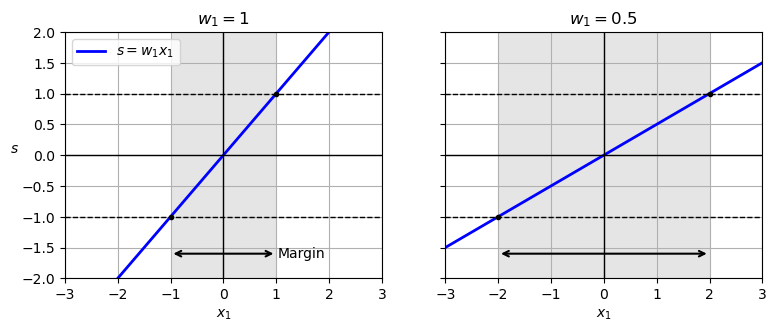

In [20]:
import matplotlib.patches as patches

def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    half_margin = 1 / w

    plt.plot(x1, y, "b-", linewidth=2, label=r"$s = w_1 x_1$")
    plt.axhline(y=0, color='k', linewidth=1)
    plt.axvline(x=0, color='k', linewidth=1)
    rect = patches.Rectangle((-half_margin, -2), 2 * half_margin, 4,
                             edgecolor='none', facecolor='gray', alpha=0.2)
    plt.gca().add_patch(rect)
    plt.plot([-3, 3], [1, 1], "k--", linewidth=1)
    plt.plot([-3, 3], [-1, -1], "k--", linewidth=1)
    plt.plot(half_margin, 1, "k.")
    plt.plot(-half_margin, -1, "k.")
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel("$x_1$")
    if ylabel:
        plt.ylabel("$s$", rotation=0, labelpad=5)
        plt.legend()
        plt.text(1.02, -1.6, "Margin", ha="left", va="center", color="k")

    plt.annotate(
        '', xy=(-half_margin, -1.6), xytext=(half_margin, -1.6),
        arrowprops={'ec': 'k', 'arrowstyle': '<->', 'linewidth': 1.5}
    )
    plt.title(f"$w_1 = {w}$")

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.grid()
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
plt.grid()
plt.show()

Se define los bordes de la calle como los puntos donde la función de decisión es igual a -1 y 1, a la izquierda el peso es $w_1 = 1$, así que los puntos donde se tocan los bordes son $x_1 = -1, +1$, por lo tanto el tamaño del margen es 2. A la derecha el peso es $w_1 = 0.5$, por lo tanto los puntos donde se tocan los bordes son $x_1 = -2, +2$, el tamaño del margen es 4. 

Por lo tanto queremos tener $w$ tan pequeño como podamos, el termino del sesog $b$ no tiene que ver con el tamaño del margen, cambiarlo solo cambiará la posición del margen.

También queremos evitar violaciones del margen, por lo tanto necesitamos que la función de decisión sea más grande que 1 para las observaciones positivas y menor a -1 para las observaciones negativas. Definimos $t^{(i)} = -1$ para observaciones negativas (cuando $y^{(i)} = 0$ y $t^{(i)} = 1$ para observaciones positivas (cuando $y^{(i)} = 1$, luego se puede escribir esta restricción como $t^{(i)}(w^TX^{(i)} + b) \geq 1$ para todas las observaciones.

Expresamos el objetivo del clasificador linear SVM con margenes duros como el siguiente problema de optimización:

$$
\text{minimizar} \hspace{0.5cm} \frac{1}{2}w^Tw
$$

$$
\text{sujeto a} \hspace{0.5cm} t^{(i)}(w^TX^{(i)} + b) \geq 1
$$


Para encontrar el objetivo de los margenes suaves necesitamos introducir una variable *slack* $\zeta^i \geq 0$ para cada observación, esta variable mide que tanto la observacion i-esima tiene permitido violar el margen. 

Ahora tenemos que hacer las variables slack lo más pequeñas que podamos para reducir las violaciones de margen y hacer $1\/2 2^Tw$ lo más pequeño posible para incrementar el margen. obtenemos la siguiente ecuación con restriccion para optimizar. Aqui entra el hiperparámetro C, nos permite definir el intercambio entre estos dos objetivos.

$$
\text{minimizar} \hspace{0.5cm} \frac{1}{2}w^Tw + C\sum\zeta^i
$$

$$
\text{sujeto a} \hspace{0.5cm} t^{(i)}(w^TX^{(i)} + b) \geq 1 - \zeta^i
$$

El probelma del margen duro y suave son ambas problemas de optimización convexas cuadraticas, se conocen como problemas de programación cuadrática (QP).

Usando un solucionador QP es una forma de entrenar un SVM, otra forma es con descenso de gradiente para minizar la *hinge loss* o *squared hinge loss*.

Dada una observación x de la clase positiva la perdida es 0 si el output s de la función de decisión $(s = w^Tx + b)$ es mayor o igual a 1, esto pasa cuando la observacion está fuera de la calle y en el lado positivo; dada una observación de la clase negativa, la perdida es 0 si $s \leq -1$. Entre más lejos esté una observación del lado correcto del margen, más alta la perdida,  la perdida crece lineal para la *hinge loss* y cuadrática para la *squared hinge loss*. La *squared hinge loss* es más sensible a outliers, si los datos están limpios tienden a convergir rápido.

LinearSVC usa la cuadrada, SGDClassifier usa la *hinge loss*, se pueden ajustar con el hiperparámetro `loss`.

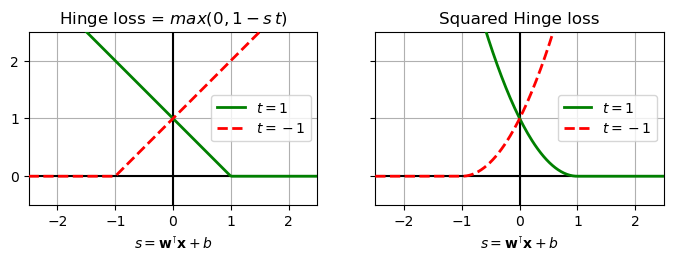

In [21]:
s = np.linspace(-2.5, 2.5, 200)
hinge_pos = np.where(1 - s < 0, 0, 1 - s)  # max(0, 1 - s)
hinge_neg = np.where(1 + s < 0, 0, 1 + s)  # max(0, 1 + s)

titles = (r"Hinge loss = $max(0, 1 - s\,t)$", "Squared Hinge loss")

fix, axs = plt.subplots(1, 2, sharey=True, figsize=(8.2, 3))

for ax, loss_pos, loss_neg, title in zip(
        axs, (hinge_pos, hinge_pos ** 2), (hinge_neg, hinge_neg ** 2), titles):
    ax.plot(s, loss_pos, "g-", linewidth=2, zorder=10, label="$t=1$")
    ax.plot(s, loss_neg, "r--", linewidth=2, zorder=10, label="$t=-1$")
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.set_xlabel(r"$s = \mathbf{w}^\intercal \mathbf{x} + b$")
    ax.axis([-2.5, 2.5, -0.5, 2.5])
    ax.legend(loc="center right")
    ax.set_title(title)
    ax.set_yticks(np.arange(0, 2.5, 1))
    ax.set_aspect("equal")

plt.show()

### El problema dual

Dado un problema de optimización con restricción, conocido como el problema primal, es posible expresar un problema diferente pero muy relacionado, llamada el problema dual.

La solución al problema dual usualmente da un limite inferior a la solucion del problema primal, pero bajo ciertas circunstancias puede ser la misma solución. El SVM cumple estas condiciones, por lo tanto se puede solucionar el problema primal o el problema dual, el problema dual es el siguiente:

$$
\text{minimizar} \frac{1}{2}\sum_{i=1}\sum_{j=1}\alpha^i\alpha^jt^it^jx^{iT}x^j - \sum_{i=1}\alpha^i
$$

$$
\text{sujeto a} \hspace{0.2cm} \alpha^i \geq 0 \hspace{0.2cm} \text{y} \hspace{0.2cm} \sum_{i=1}\alpha^it^i=0
$$

Una vez se encuentre el vector $\hat{a}$ que minimiza esta ecuación (usando un solucionador QP), se usa la siguiente ecuación para computar el $\hat{w}$ y $\hat{b}$ que minimicen el problema primal, en la ecuación $n_s$ representa el numero de vectores soporte.

$$
\hat{w} = \sum_{i=1} \hat{a}^it^ix^i \\
\hat{b} = \frac{1}{n_s} \sum_{i=1}(t^i = \hat{w}^Tx^i) \\
\hat{a}^i > 0
$$

El problema dual es más rápido de resolver y hace que el truco de kernel sea posible.

### SVM kernelizados

Supongamos que se quiere aplicar un polinomio de segundo grado a un conjunto de datos de dos dimensiones, luego entrenar un clasificador SVM lineal en el conjunto transformado:

$$
\phi(x) = \phi \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} = \begin{pmatrix} x_1^2 \\ \sqrt{2}x_1x_2 \\ x_2^2 \end{pmatrix}
$$

Ahora el vector transformado es 3D y no 2D, ahora veamos que le pasa a dos vectores, a y b, si aplicamos este mapeado de polinomio de segundo grado y computamos el producto punto del vector transformado.

$$
\phi(a)^T\phi(b) = \begin{pmatrix} a_1^2\\ \sqrt{2}a_1a_2\\ a_2^2 \end{pmatrix}^T \begin{pmatrix} b_1^2\\ \sqrt{2}b_1b_2\\ b_2^2 \end{pmatrix} = a_1^2b_1^2 + 2a_1b_1a_2b_2+a_2^2b_2^2 \\
= (a_1b_1 + a_2b_2)^2 = \left(\begin{pmatrix} a_1 \\ a_2 \end{pmatrix}^T\begin{pmatrix} b_1 \\ b_2 \end{pmatrix}\right)^2 = (a^Tb)^2
$$

El producto punto de los vectores transformados es igual al cuadrado del producto punto de los vecotre originales.

Si se aplica la transformación $\phi$ a las observaciones de entrenamiento entonces el problema dual va a contener el producto punto $\phi(x^i)^T\phi(x^j)$, si $\phi$ es el polinomio de segundo grado podemos reemplazar este producto punto simplemente por $(x^{(i)T}x^j)^2$ así que no se necesita transformar las observaciones de entrenamiento, solo reemplazar el producto punto por su cuadrado, el resultado sería el mismo que si se hubieran hecho las transformaciones pero mucho más eficiente.

la función $K(a, b) = (a^Tb)^2$ es un kernel de polinomio de segundo grado, en machine learning, un kernel es una función capaz de computar el producto punto $\phi(a)^T\phi(b)$, basado solo en los vectores originales a y b, sin tener que computar las transformaciones $\phi$, algunos kernels comunes son:

\begin{split}
\text{Lineal:}  &K(a, b) = a^Tb \\
\text{Polynomial:} &K(a, b) = (\gamma a^Tb + r)^d \\
\text{Gaussian RBF:}  &K(a, b) = \exp(-\gamma||a-b||^2) \\
\text{sigmoid:}  &K(a, b) = \tanh(\gamma a^Tb + r)
\end{split}

[Teorema de Mercer](https://en.wikipedia.org/wiki/Mercer%27s_theorem) El teorema que basa la teoría de los kernels y el muestreo a otras dimensiones

Ahora, para hacer estimaciones sin saber \hat{w}, podemos insertar la formula de \hat{w} en la función de decisión para una nueva observación, termina con una ecuación con solo productos punto entre vectores de input, esto hace posible usar el truco de kernel.

\begin{aligned}
h_{\widehat{\mathbf{w}}, \hat{b}}\left(\varphi\left(\mathbf{x}^{(n)}\right)\right)= & \widehat{\mathbf{w}}^{\top} \varphi\left(\mathbf{x}^{(n)}\right)+\widehat{b}=\left(\sum_{i=1}^m \widehat{\alpha}^{(i)} t^{(i)} \varphi\left(\mathbf{x}^{(i)}\right)\right)^{\top} \varphi\left(\mathbf{x}^{(n)}\right)+\widehat{b} \\
= & \sum_{i=1}^m \widehat{\alpha}^{(i)} t^{(i)}\left(\varphi\left(\mathbf{x}^{(i)}\right)^{\top} \varphi\left(\mathbf{x}^{(n)}\right)\right)+\widehat{b} \\
= & \sum_{\substack{i=1 \\
\widehat{\alpha}^{(i)}>0}}^m \widehat{\alpha}^{(i)} t^{(i)} K\left(\mathbf{x}^{(i)}, \mathbf{x}^{(n)}\right)+\widehat{b}
\end{aligned}

Hacer predicciones solo depende de los vectores de soporte, no todas las observaciones de entrenamiento, se puede usar el mismo truco para computar el termino de sesgo

\begin{aligned}
& \widehat{b}=\frac{1}{n_s} \sum_{i=1}^m\left(t^{(i)}-\widehat{\mathbf{w}}^{\top} \varphi\left(\mathbf{x}^{(i)}\right)\right)=\frac{1}{n_s} \sum_{i=1}^m\left(t^{(i)}-\left(\sum_{j=1}^m \widehat{\alpha}^{(j)} t^{(j)} \varphi\left(\mathbf{x}^{(j)}\right)\right)^{\top} \varphi\left(\mathbf{x}^{(i)}\right)\right) \\
& \widehat{\alpha}^{(i)}>0 \quad \widehat{\alpha}^{(i)}>0 \\
& =\frac{1}{n_s} \sum_{\substack{i=1 \\
\hat{\alpha}^{(i)}>0}}^m\left(t^{(i)}-\sum_{\substack{j=1 \\
\hat{\alpha}^{(j)}>0}}^m \widehat{\alpha}^{(j)} t^{(j)} K\left(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}\right)\right) \\
&
\end{aligned}

## Ejercicios

1. What is the fundamental idea behind support vector machines?

La idea fundamental detras del SVM es crear una calle con dos limites, cuyos limites están en las observaciones vectores soporte. Ajustar la calle más ancha posible entre las clases. Tener el margen más grande posible entre los limites de decisión que separan ambas clases. Al hacer clasificación con margen suave tiene un compromiso entre tener la calle más ancha posible y separar las dos clases lo mayor posible.

2. What is a support vector?

Un vector de soporte son las observaciones que, después de entrenar el modelo, está ubicada en la calle o en el borde, el limite de decisión está determinado completamente por los vectores de soporte, cualquier observación que no sea un vector de soporte no tiene influencia. Computar las predicciones con un SVM kernelizado solo depende los vectores de soporte.

3. Why is it important to scale the inputs when using SVMs?

Al ajustar la calle más larga posible entre clases, si las variables no están escaladas, el SVM tiende a ignorar las variables pequeñas.

4. Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?

Se puede usar el metodo decision_function() para obtener los puntajes de confianza, son la distancia entre la observación y el limite de decisión pero no pueden ser convertidos en una estimación de probabilidad de clases, al establecer `probability = True`, al final del entrenamiento hace validación cruzada para generar puntajes fuera de la muestra para las muestras de entrenamiento y entrena una regresion logistica para mapear estos puntajes a probabilidades estimadas, despues de esto se puede llamar el metodo `predict_proba` y `predict_log_proba()`.

5. How can you choose between LinearSVC, SVC, and SGDClassifier?

Las tres clases se pueden usar para clasificacion lineal de margen largo. la clase `SVC` admite el truco de kernel, por lo cual soporta tareas no lineales. `SVC` no escala bien con conjuntos de datos de muchas observaciones pero escala bien con muchas variables. `LinearSVC` implementa optimización para SVM lineales, `SGDClassifier` usa descenso de gradiente estocastico.

6. Say you’ve trained an SVM classifier with an RBF kernel, but it seems to underfit the training set. Should you increase or decrease γ (gamma)? What about C?

Si el modelo subajusta tal vez haya mucha regularización, se deberían aumentar tanto el $\gamma$ como el C.

7. What does it mean for a model to be ϵ-insensitive?

El tamaño de la calle depende basicamente del parámetro $\epsilon$, por eso el modelo es $\epsilon$ dependiente. El modelo trata de ajustar la mayor cantidad de observaciones  con un margen pequeño alrededor de sus predicciones, si se agregan observaciones dentro del margen el modelo no se afecta para nada.

8. What is the point of using the kernel trick?

La idea del truco del Kernel es poder entrenar modelos no lineales, el modelo se basa en mapear los inputs a otro espacio usando una transformación no lineal, luego entrenar un modelo lineal en el resultado. tener una mayor eficiencia de computación.

9. Train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.

In [33]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

(150, 2)


(100, 2)

In [34]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler 

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss = 'hinge', C = C, random_state = 42)
svm_clf = SVC(kernel = 'linear', C=C)
sgd_clf = SGDClassifier(loss = 'hinge', learning_rate = 'constant', eta0 = 0.001, alpha = alpha,
                       max_iter = 1000, tol = 1e-3, random_state = 42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print('SVC lineal:                    ', lin_clf.intercept_, lin_clf.coef_)
print('SVC:                           ', svm_clf.intercept_, svm_clf.coef_)
print('Clasificador SGD(alpha={:.5f}):'.format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

SVC lineal:                     [0.28475098] [[1.05364854 1.09903804]]
SVC:                            [0.31896852] [[1.1203284  1.02625193]]
Clasificador SGD(alpha=0.00200): [0.117] [[0.77714169 0.72981762]]


Ahora graficar los limites de decisión de los tres

In [50]:
# intercepto y pendiente de cada uno
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

In [51]:
# transformar las lineas de decisión a su escala original

line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

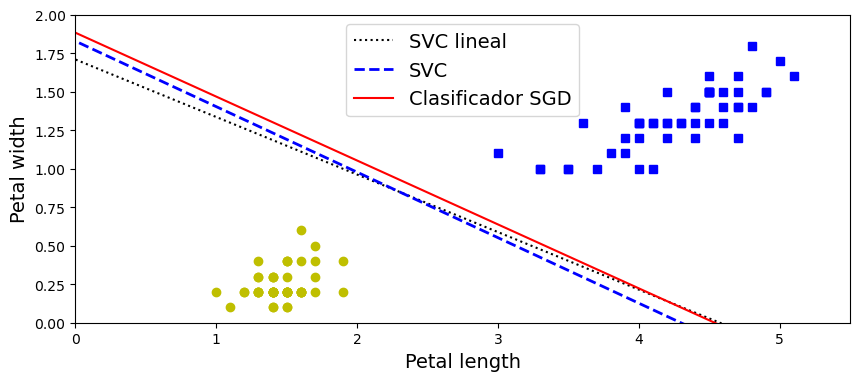

In [56]:
# Graficar

plt.figure(figsize = (10, 4))
plt.plot(line1[:, 0], line1[:, 1], 'k:', label = 'SVC lineal')
plt.plot(line2[:, 0], line2[:, 1], 'b--', linewidth = 2, label = 'SVC')
plt.plot(line3[:, 0], line3[:, 1], 'r-', label = 'Clasificador SGD')
plt.plot(X[:, 0][y==1], X[:, 1][y == 1], 'bs'); # iris versicolor
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # Iris setosa
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])
plt.show()

10. Train an SVM classifier on the wine dataset, which you can load using sklearn.datasets.load_wine(). This dataset contains the chemical analyses of 178 wine samples produced by 3 different cultivators: the goal is to train a classification model capable of predicting the cultivator based on the wine’s chemical analysis. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all three classes. What accuracy can you reach?

In [74]:
import pandas as pd
from sklearn.datasets import load_wine
wine = load_wine(as_frame = True)
X = wine['data']
y = wine['target']

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [96]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
100,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0


In [97]:
y_train.head()

2      0
100    1
122    1
154    2
51     0
Name: target, dtype: int32

In [99]:
lin_clf = LinearSVC(random_state = 42) # automaticamente usa el one vs all (one vs rest)
lin_clf.fit(X_train, y_train) # no converge, tal vez aumentando las iteraciones.

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42)

In [101]:
lin_clf = LinearSVC(max_iter = 1_000_000, random_state = 42)
lin_clf.fit(X_train, y_train)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=1000000, random_state=42)

Ni con un millon de iteraciones convergió, debe haber otro problema. 

Evaluar el modelo con `cross_val_score` sirve como una base

In [102]:
from sklearn.model_selection import cross_val_score

cross_val_score(lin_clf, X_train, y_train).mean()

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.90997150997151

Lo que está faltando es escalar las variables! con SVM siempre se tienen que escalar las variables

In [106]:
lin_clf = make_pipeline(StandardScaler(),
                      LinearSVC(random_state = 42))
lin_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=42))])

In [107]:
cross_val_score(lin_clf, X_train, y_train).mean()

0.9774928774928775

Ahora veamos con una SVM kernelizado

In [108]:
svm_clf = make_pipeline(StandardScaler(),
                       SVC(random_state = 42))
cross_val_score(svm_clf, X_train, y_train).mean()

0.9698005698005698

Intentemos ajustar los hiperparámetros

In [114]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

param_distrib = {
    'svc__gamma': loguniform(0.001, 0.1),
    'svc__C': uniform(1, 10)
}

rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter = 100, cv = 5,
                               random_state = 42)
rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=9.925589984899778, gamma=0.011986281799901176,
                     random_state=42))])

In [115]:
rnd_search_cv.best_score_

0.9925925925925926

Mejoró mucho, ahora probemoslo con los datos de prueba

In [116]:
rnd_search_cv.score(X_test, y_test)

0.9777777777777777

11. Train and fine-tune an SVM regressor on the California housing dataset. You can use the original dataset rather than the tweaked version we used in Chapter 2, which you can load using sklearn.datasets.fetch_california_housing(). The targets represent hundreds of thousands of dollars. Since there are over 20,000 instances, SVMs can be slow, so for hyperparameter tuning you should use far fewer instances (e.g., 2,000) to test many more hyperparameter combinations. What is your best model’s RMSE?

In [117]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing.data
y = housing.target

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                  random_state = 42)

In [120]:
lin_svr = make_pipeline(StandardScaler(),
                       LinearSVR(random_state = 42))
lin_svr.fit(X_train, y_train)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(random_state=42))])

No convergió, aumentemos el numero de iteraciones

In [121]:
lin_svr = make_pipeline(StandardScaler(),
                       LinearSVR(max_iter = 5000, random_state = 42))
lin_svr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(max_iter=5000, random_state=42))])

In [122]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
mse

0.9595484665813284

In [123]:
np.sqrt(mse)

0.979565447829459

Esto es aproximadamente 98000 de error, no muy bueno, intentemos con un kerned RBF

In [124]:
svm_clf = make_pipeline(StandardScaler(), 
                        SVR())

param_distrib = {
    'svr__gamma': loguniform(0.001, 0.1),
    'svr__C': uniform(1, 10)
}

rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib,
                                  n_iter = 100, cv = 3, random_state = 42)
rnd_search_cv.fit(X_train[:2000], y_train[:2000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=100,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002AB0314D280>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002AB0214D9D0>},
                   random_state=42)

In [125]:
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=4.63629602379294, gamma=0.08781408196485974))])

In [126]:
-cross_val_score(rnd_search_cv.best_estimator_, X_train, y_train,
                scoring = 'neg_root_mean_squared_error')

array([0.58835648, 0.57468589, 0.58085278, 0.57109886, 0.59853029])

In [127]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared = False)
rmse

0.585473226517223

Mejoró pero el modelo de random forest daba un mejor error.